In [199]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [200]:
!which python

/Users/ziru/miniforge3/envs/gesture_input/bin/python


### Preprocessing

In [201]:

def normalize(acc_values, gyr_values):
    ACC_MIN, ACC_MAX = -2.0, 2.0  # 加速度计通常在±2g范围
    GYR_MIN, GYR_MAX = -500.0, 500.0  # 陀螺仪通常在±500度/秒范围
    norm_acc = 2 * (np.array(acc_values) - ACC_MIN) / (ACC_MAX - ACC_MIN) - 1
    norm_gyr = 2 * (np.array(gyr_values) - GYR_MIN) / (GYR_MAX - GYR_MIN) - 1
    norm_acc = np.clip(norm_acc, -1, 1)
    norm_gyr = np.clip(norm_gyr, -1, 1)
    return norm_acc, norm_gyr

# Data root directory
data_folder = Path("./data/")

# Store gesture data and total durations
gesture_data = {}
gesture_durations = {}  # Store total duration for each gesture

# Step 1: Collect gesture data from all user directories and calculate total duration
print("Collecting user data and calculating total duration...")
for user_dir in sorted(data_folder.glob("user_*")):
    print(f"Processing user: {user_dir.name}")
    
    for gesture_file in sorted(user_dir.glob("*.csv"), key=lambda x: x.stem):
        gesture_name = gesture_file.stem
        df = pd.read_csv(gesture_file)

        # Skip the first and last 0.5 seconds
        min_time, max_time = df["timestamp"].min(), df["timestamp"].max()
        df_filtered = df[(df["timestamp"] >= min_time + 0.5) & 
                         (df["timestamp"] <= max_time - 0.5)].reset_index(drop=True)

        if gesture_name not in gesture_data:
            gesture_data[gesture_name] = []
            gesture_durations[gesture_name] = 0
        
        # Calculate the duration of this gesture sample and add to the total duration
        sample_duration = df_filtered["timestamp"].max() - df_filtered["timestamp"].min()
        gesture_durations[gesture_name] += sample_duration
        
        # Save the processed data
        gesture_data[gesture_name].append(df_filtered)

# Statistics: Total duration and sample count for each gesture
print("\nGesture data statistics:")
for gesture_name, dfs in gesture_data.items():
    total_samples = sum(len(df) for df in dfs)



def normalize(acc_values, gyr_values):
    # 预定义的传感器数据范围
    ACC_MIN, ACC_MAX = -2.0, 2.0  # 加速度计通常在±2g范围
    GYR_MIN, GYR_MAX = -500.0, 500.0  # 陀螺仪通常在±500度/秒范围
    
    # 归一化到 [-1,1]
    norm_acc = 2 * (np.array(acc_values) - ACC_MIN) / (ACC_MAX - ACC_MIN) - 1
    norm_gyr = 2 * (np.array(gyr_values) - GYR_MIN) / (GYR_MAX - GYR_MIN) - 1
    
    # 确保值在 [-1,1] 范围内（处理超出预期范围的异常值）
    norm_acc = np.clip(norm_acc, -1, 1)
    norm_gyr = np.clip(norm_gyr, -1, 1)
    
    return norm_acc, norm_gyr


# Step 2: Merge all user data for each gesture and normalize
processed_data = {}
for gesture_name, dfs in gesture_data.items():
    # Combine all user data into a single DataFrame
    combined_df = pd.concat(dfs, ignore_index=True)
    
    # 应用归一化 - 分别处理左右传感器数据
    for i, sensor in enumerate(['left', 'right']):
        # 确定对应的列索引
        if sensor == 'left':
            acc_cols = [0, 1, 2]  # 左传感器加速度
            gyr_cols = [3, 4, 5]  # 左传感器陀螺仪
        else:
            acc_cols = [6, 7, 8]  # 右传感器加速度
            gyr_cols = [9, 10, 11]  # 右传感器陀螺仪
        
        # 提取数据
        acc_data = combined_df.iloc[:, acc_cols].values
        gyr_data = combined_df.iloc[:, gyr_cols].values
        
        # 应用归一化
        norm_acc, norm_gyr = normalize(acc_data, gyr_data)
        
        # 用归一化数据替换原始数据
        combined_df.iloc[:, acc_cols] = norm_acc
        combined_df.iloc[:, gyr_cols] = norm_gyr
    
    processed_data[gesture_name] = combined_df
    
    # Print merged statistics
    total_duration = combined_df["timestamp"].max() - combined_df["timestamp"].min()
    print(f"{gesture_name}: {len(combined_df)} samples, duration: {total_duration:.2f}s")

# Step 3: Save processed data to CSV files
output_dir = Path("./processed_data/")
output_dir.mkdir(exist_ok=True)

for gesture_name, df in processed_data.items():
    output_file = output_dir / f"{gesture_name}.csv"
    df.to_csv(output_file, index=False)
    print(f"Saved normalized data for {gesture_name} to {output_file}")

Processing user: user_1
Processing user: user_2
Processing user: user_3

Gesture data statistics:
a: 295 samples, duration: 673.89s
c: 289 samples, duration: 150.71s
d: 236 samples, duration: 670.52s
g: 258 samples, duration: 673.37s
h: 246 samples, duration: 674.95s
i: 315 samples, duration: 686.96s
l: 243 samples, duration: 673.12s
m: 238 samples, duration: 675.86s
n: 406 samples, duration: 654.90s
o: 322 samples, duration: 684.92s
t: 325 samples, duration: 726.75s
u: 247 samples, duration: 673.26s
y: 230 samples, duration: 736.47s
z: 236 samples, duration: 669.36s
Saved normalized data for a to processed_data/a.csv
Saved normalized data for c to processed_data/c.csv
Saved normalized data for d to processed_data/d.csv
Saved normalized data for g to processed_data/g.csv
Saved normalized data for h to processed_data/h.csv
Saved normalized data for i to processed_data/i.csv
Saved normalized data for l to processed_data/l.csv
Saved normalized data for m to processed_data/m.csv
Saved norm

In [202]:
# look at data from one gesture
# processed_data["u"]

手势 'a' CSV文件行数: 295
手势 'c' CSV文件行数: 289
手势 't' CSV文件行数: 325
手势 'u' CSV文件行数: 247
手势 'g' CSV文件行数: 258
手势 'd' CSV文件行数: 236
手势 'i' CSV文件行数: 315
手势 'h' CSV文件行数: 246
手势 'o' CSV文件行数: 322
手势 'y' CSV文件行数: 230
手势 'n' CSV文件行数: 406
手势 'l' CSV文件行数: 243
手势 'z' CSV文件行数: 236
手势 'm' CSV文件行数: 238


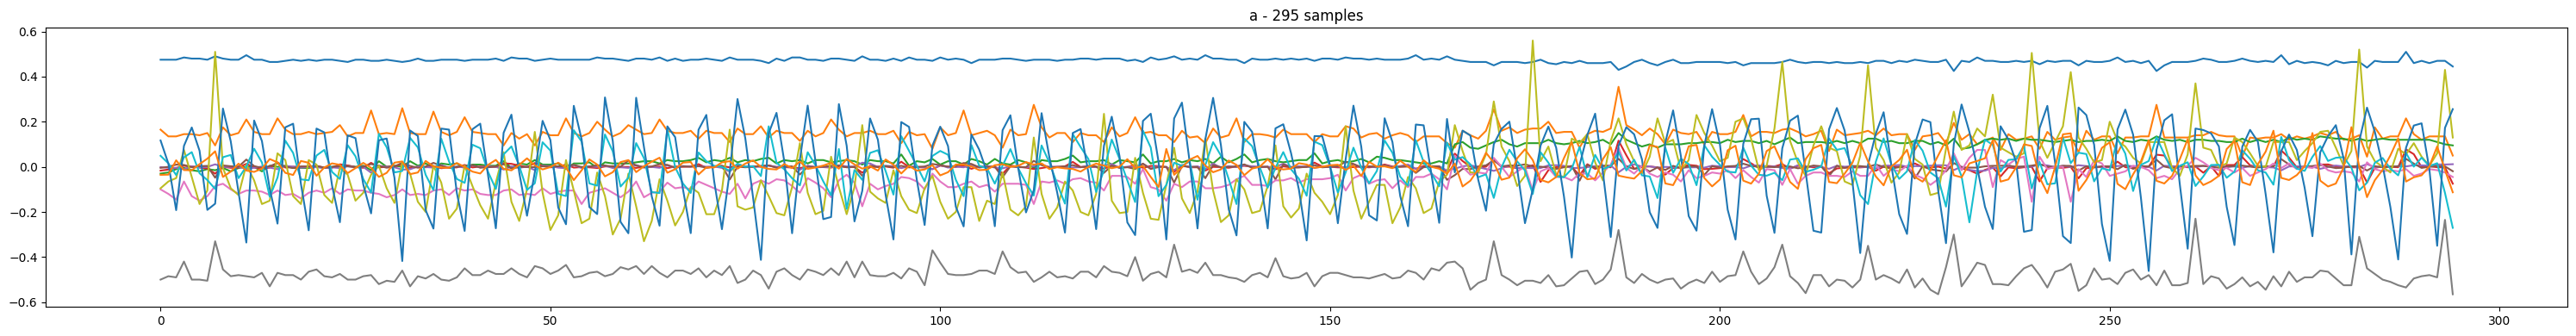

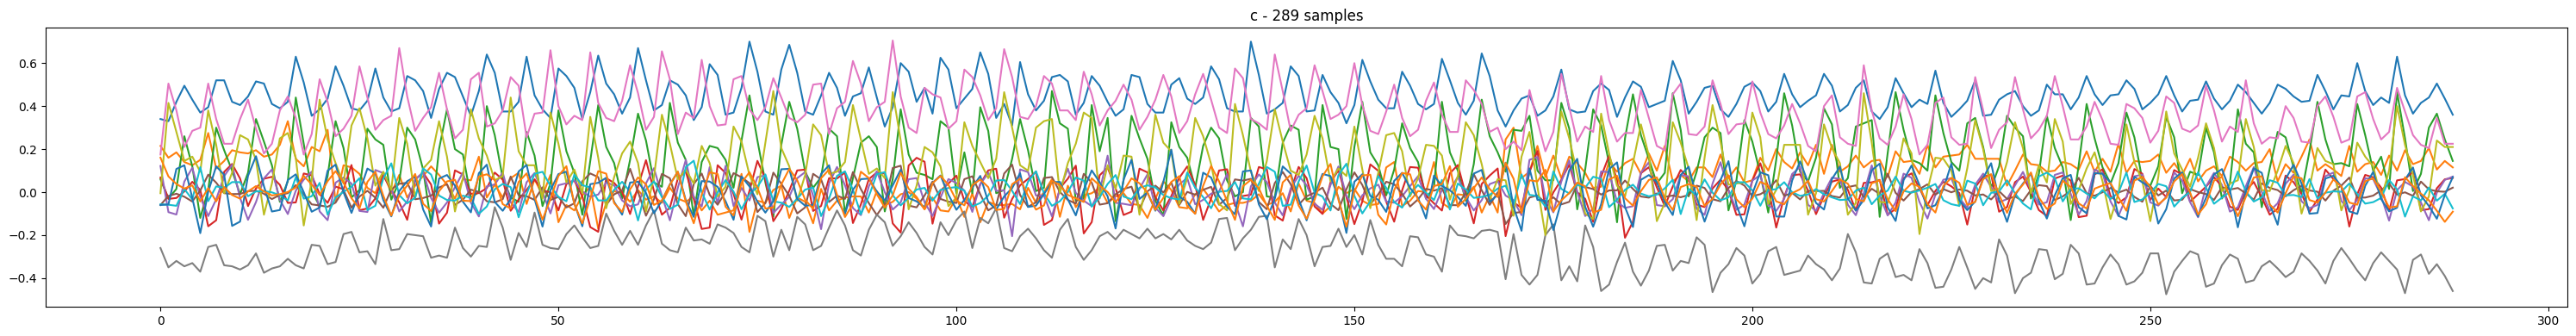

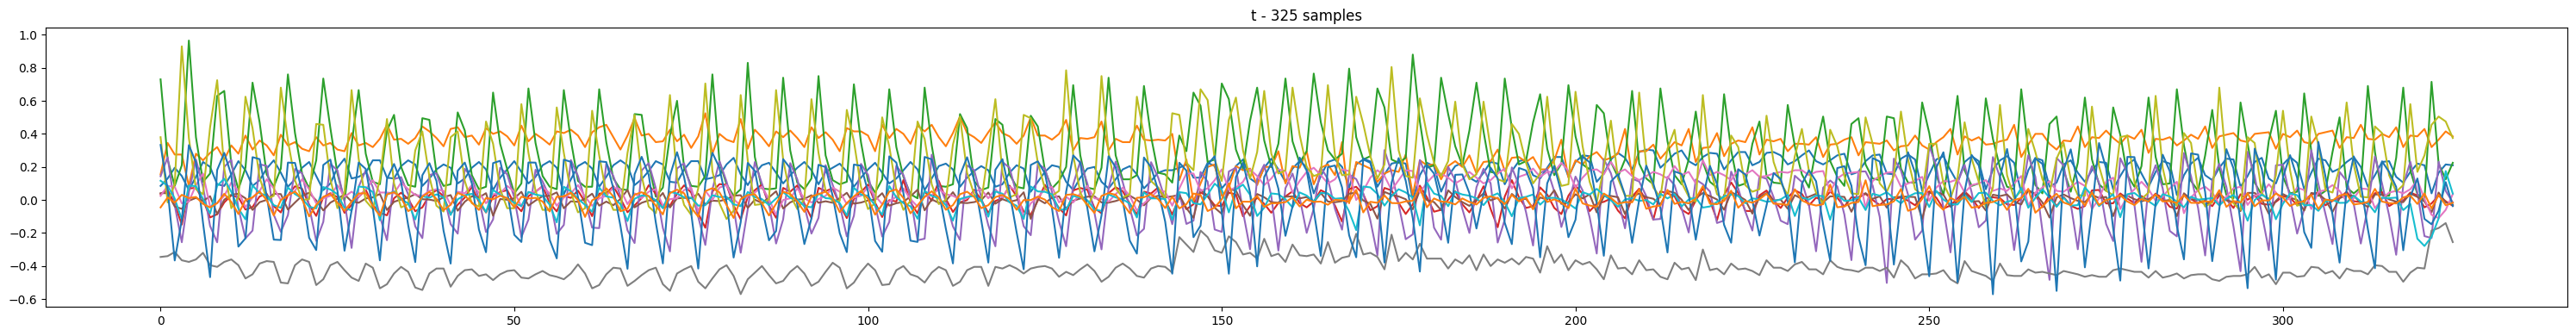

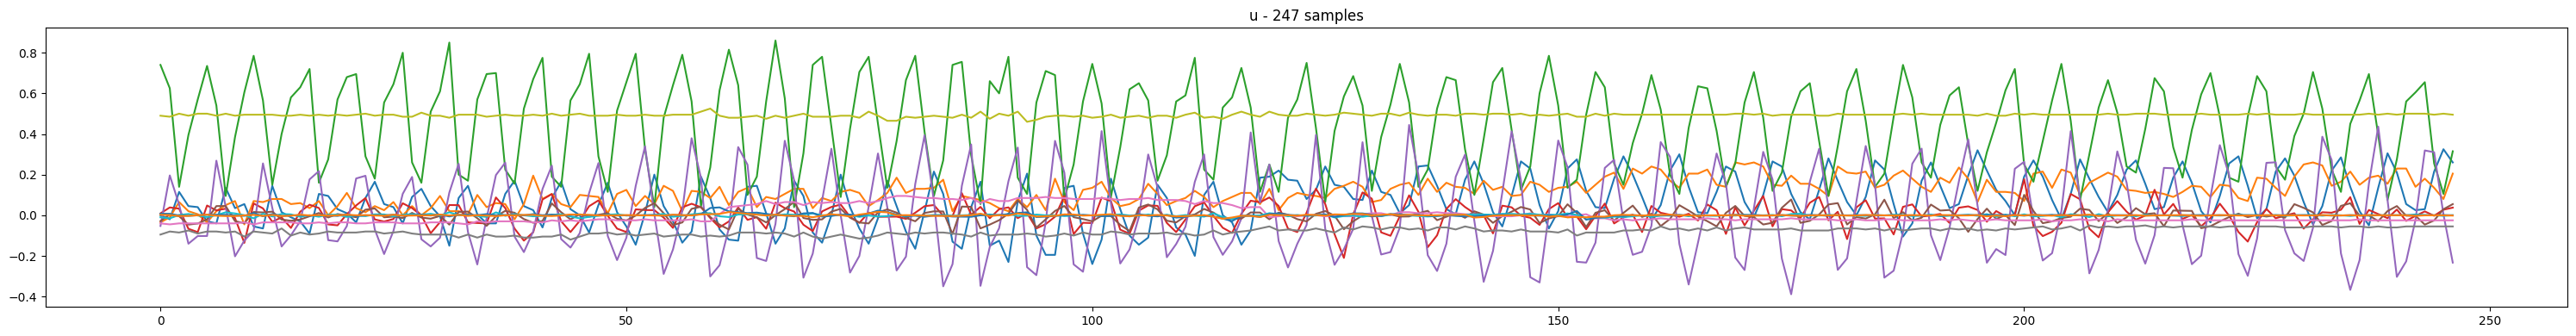

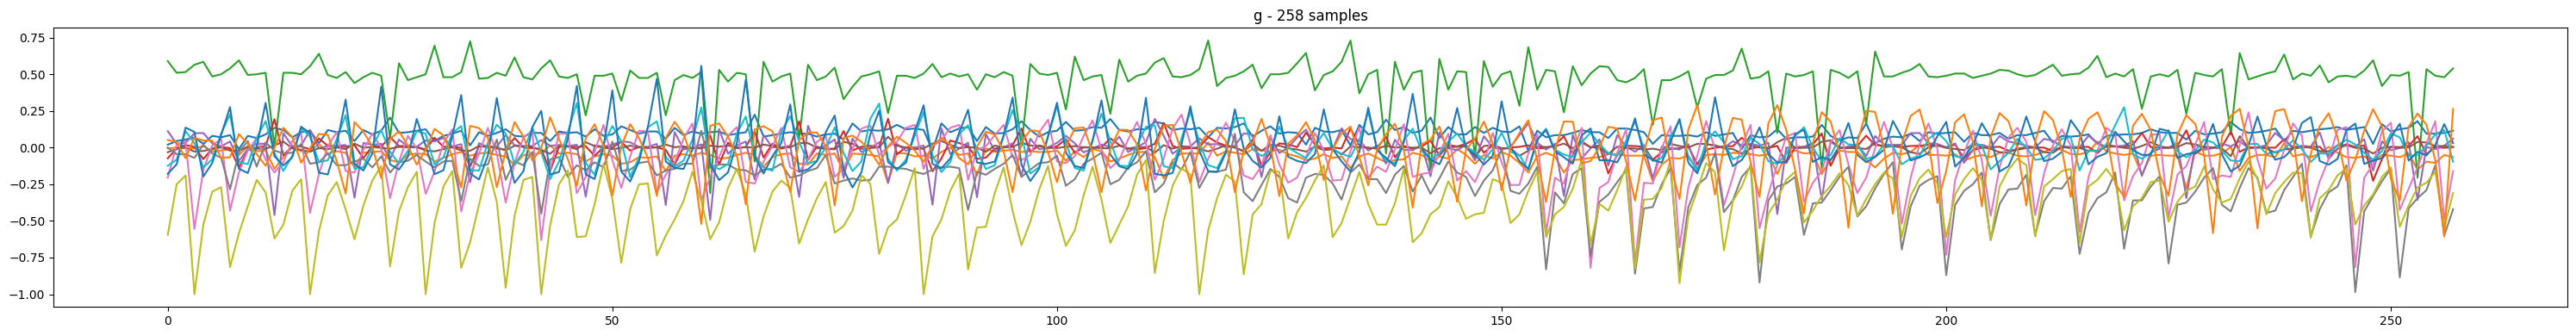

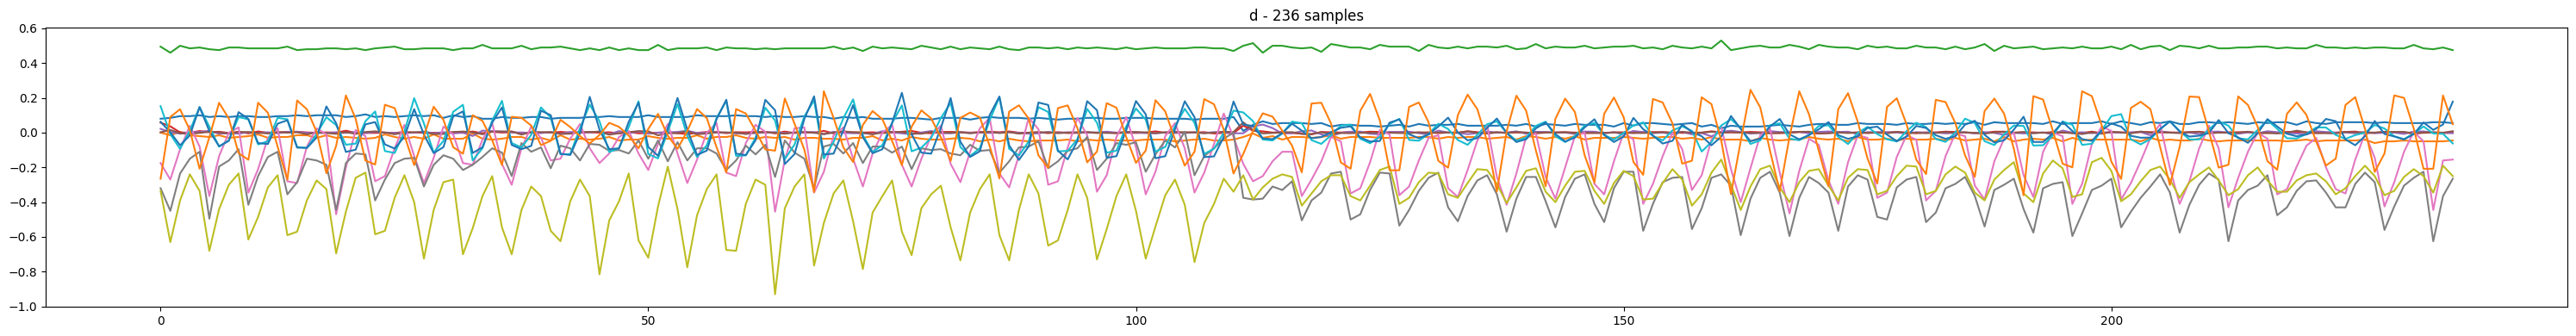

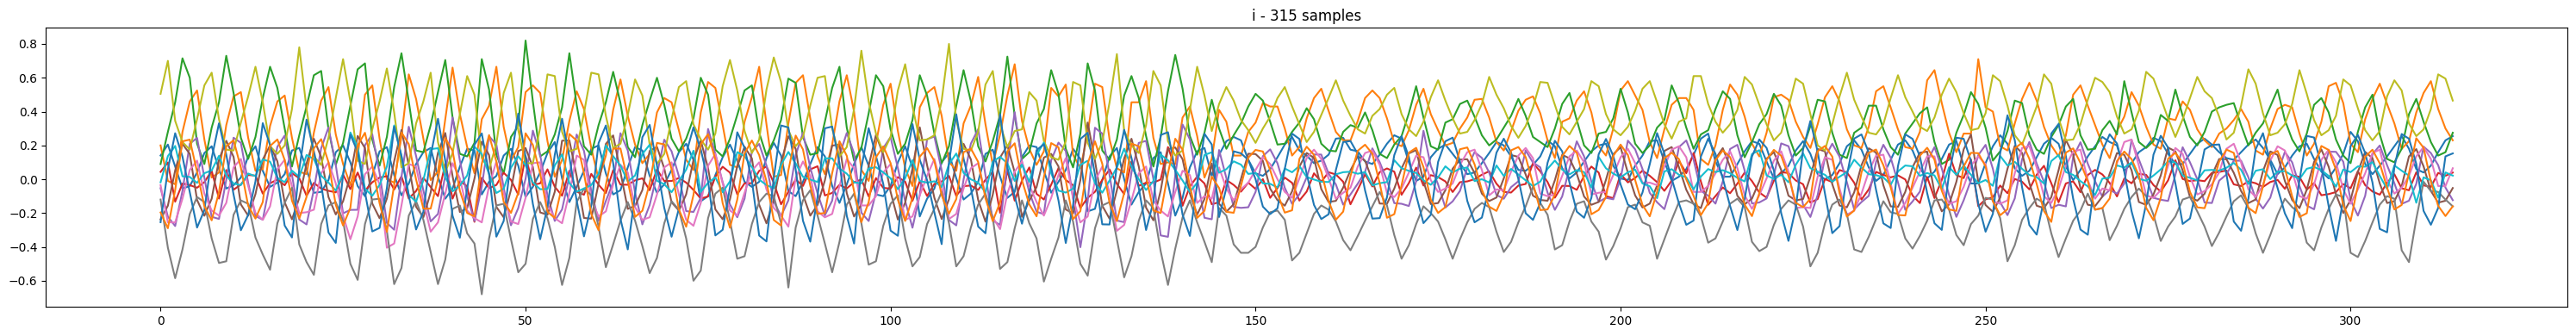

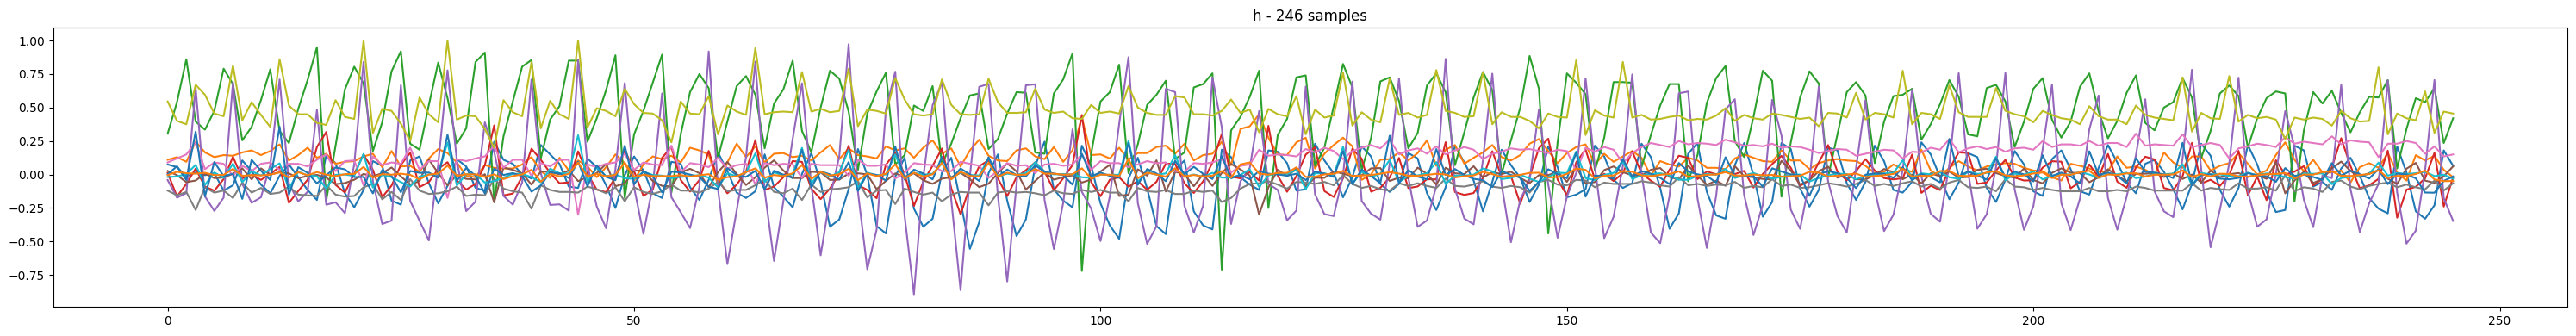

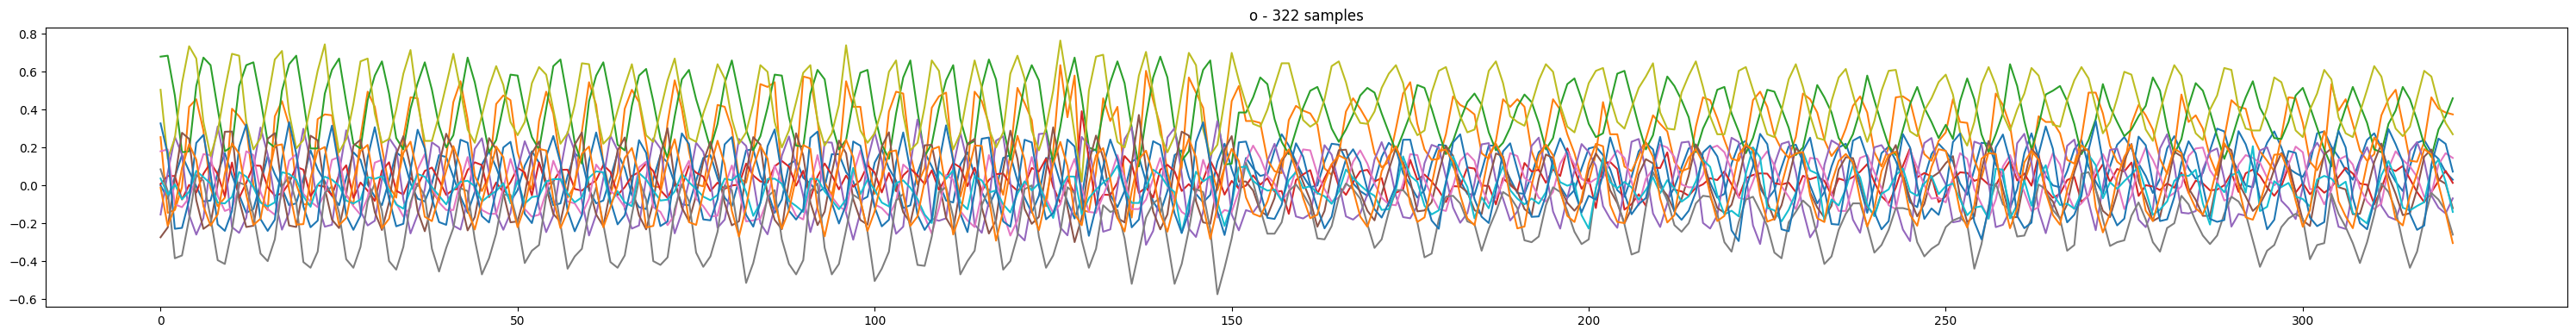

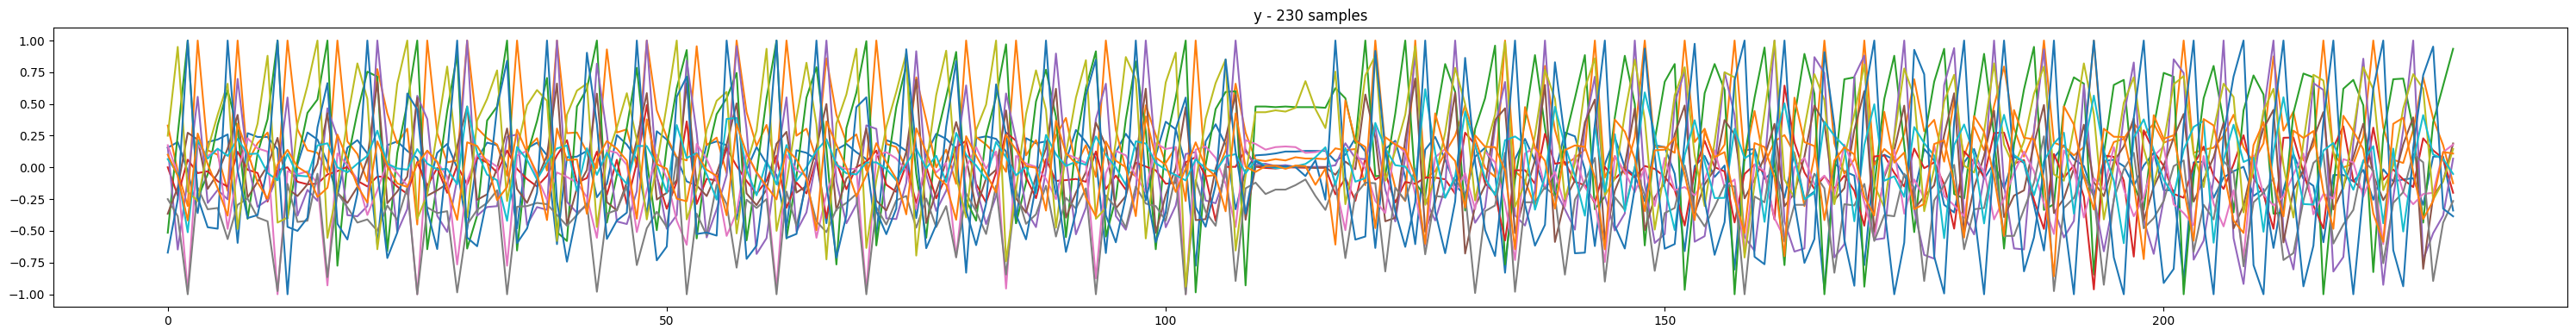

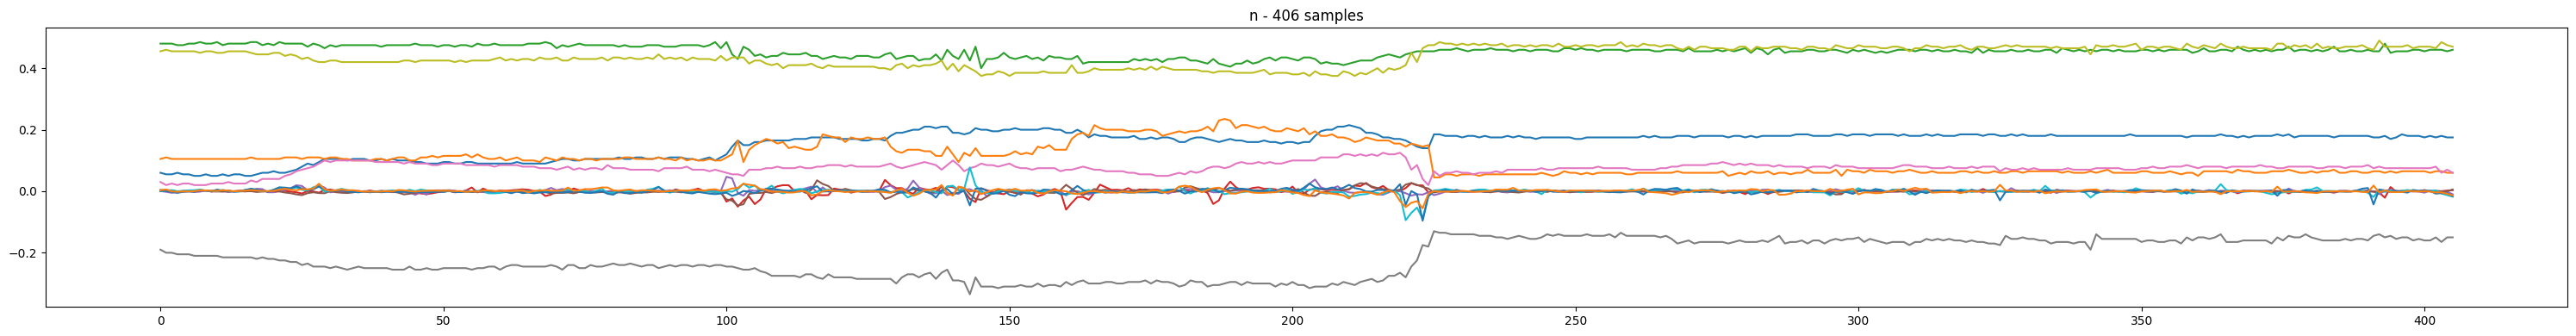

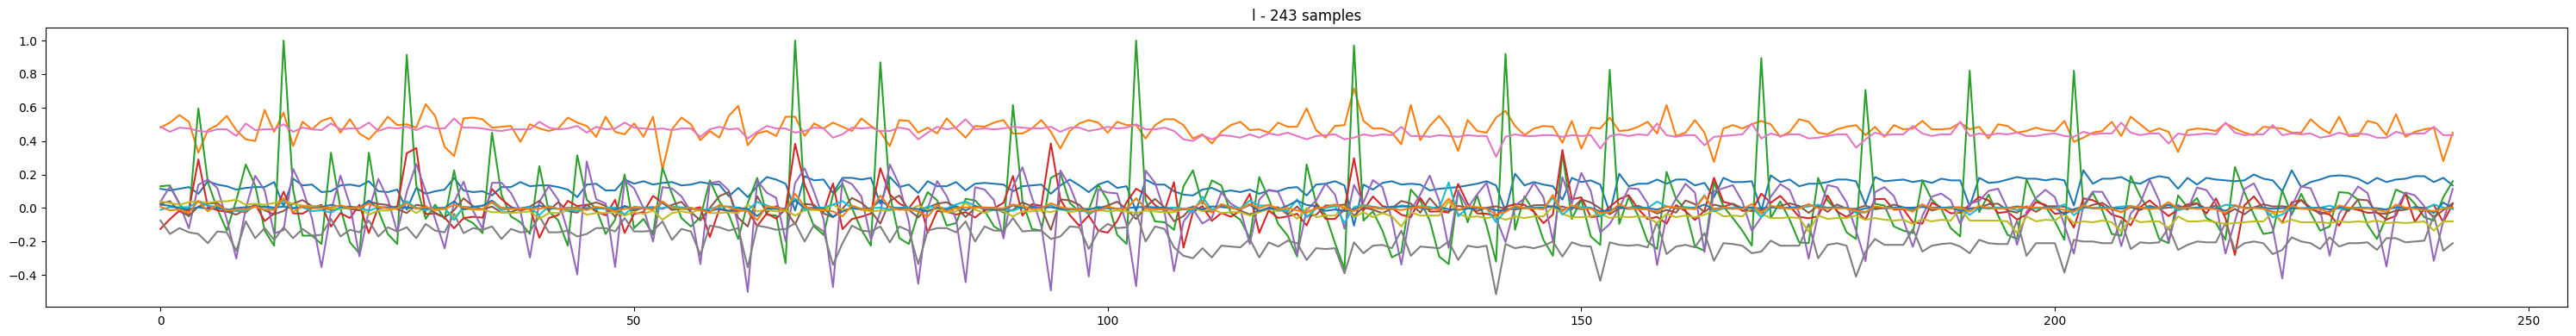

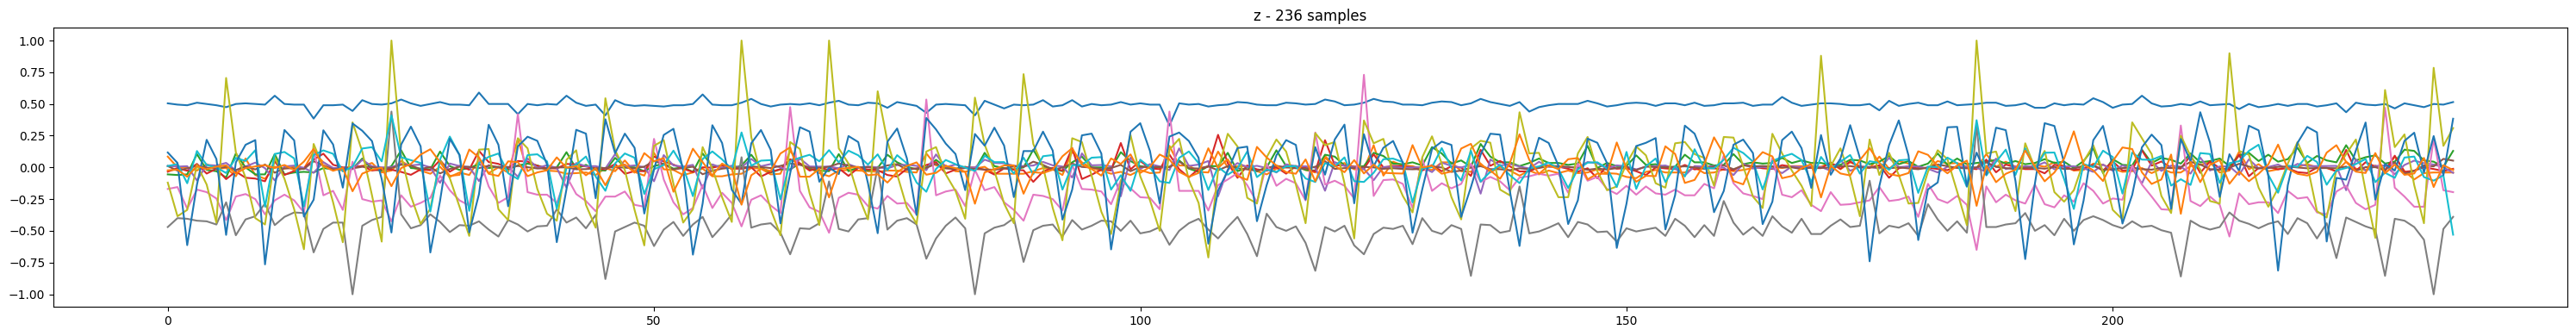

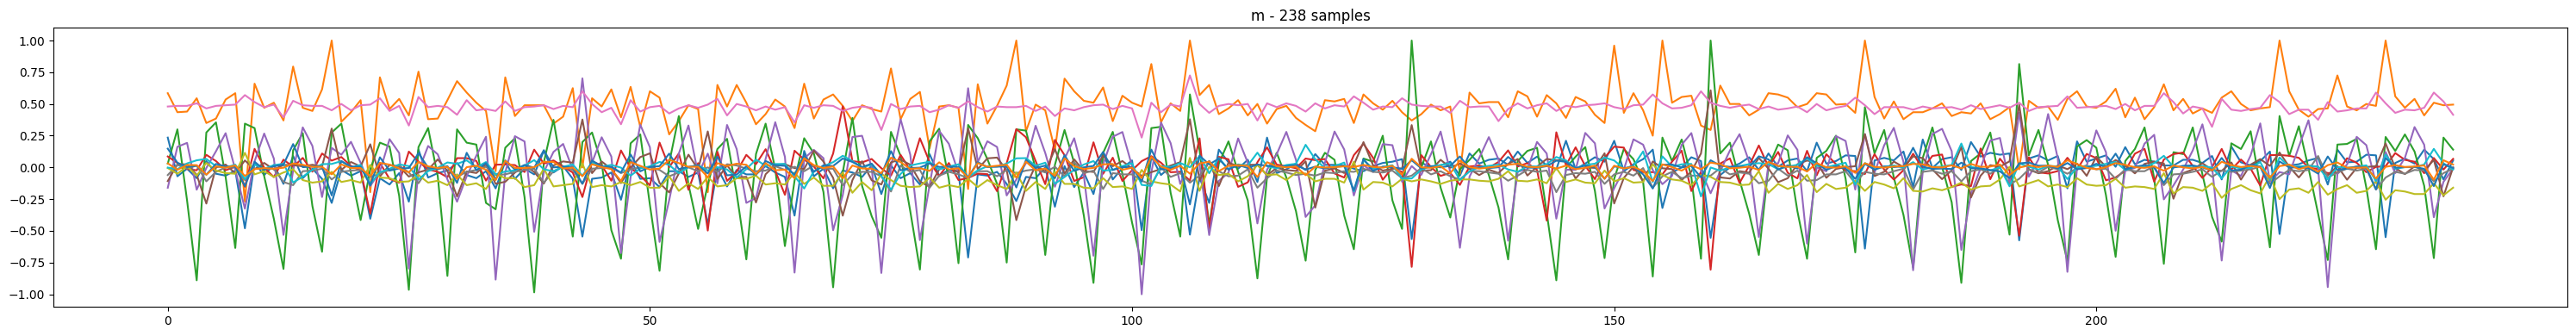

In [203]:


# 从处理后的CSV文件加载数据
processed_dir = Path("./processed_data/")
visualization_data = {}

# 加载所有处理后的CSV文件
for csv_file in processed_dir.glob("*.csv"):
    gesture_name = csv_file.stem
    df = pd.read_csv(csv_file)
    visualization_data[gesture_name] = df
    
    # 打印每个文件的行数
    print(f"手势 '{gesture_name}' CSV文件行数: {len(df)}")

# 可视化所有手势数据
for gesture_name, df in visualization_data.items():
    plt.figure(figsize=(30, 4))
    plt.title(f"{gesture_name} - {len(df)} samples")
    
    # 绘制传感器数据 (除去timestamp和user列)
    sensor_columns = [col for col in df.columns if col not in ['timestamp', 'user']]
    df[sensor_columns].plot(ax=plt.gca(), legend=False)
    
    plt.tight_layout()
    plt.show()

### Training

1. 输入层
`Input(shape=(6 * window_size,))`

- 输入形状: (6 * window_size,)，例如 (300,)（假设 window_size=50，6 个 IMU 特征）。

- 作用: 接收展平后的滑动窗口数据（每个窗口包含 50 个时间步 × 6 个传感器维度 = 300 个特征）。

2. 全连接隐藏层
`Dense(64, activation='relu')`

- 神经元数量: 64

- 激活函数: ReLU（修正线性单元），引入非线性，帮助模型学习复杂模式。

- 参数数量: (300 + 1) * 64 = 19,264（300 输入特征，64 个神经元，每个神经元有 1 个偏置项）。

3. 输出层
`Dense(len(data.keys()), activation='softmax')`

- 神经元数量: 等于手势类别数（例如 data.keys() 返回 ['wave', 'circle', 'swipe']，则神经元数为 3）。

- 激活函数: Softmax，将输出转换为概率分布（所有类别的概率之和为 1）。

- 参数数量: (64 + 1) * num_classes（例如 3 类时有 (64+1)*3=195 个参数）。

1. 优化器 (Optimizer)  优化器 (Optimizer)
Adam(learning_rate=3e-4):

自适应学习率的优化算法，结合了动量（Momentum）和 RMSProp 的优点。

learning_rate=3e-4 是初始学习率，较小的值适合精细调整权重。

2. 损失函数 (Loss)
SparseCategoricalCrossentropy():

适用于多分类任务，且标签为整数形式（例如 0, 1, 2）。

如果是 one-hot 编码标签，应使用 CategoricalCrossentropy。

3. 评估指标 (Metrics)
SparseCategoricalAccuracy(name='accuracy'):

计算分类准确率，正确预测的样本比例。

同样适用于整数标签。

模型改进思路
调整网络结构:

增加更多隐藏层（如取消注释的 Dense(64, activation='relu')）。

添加 Dropout 层防止过拟合：

python
keras.layers.Dropout(0.5)
优化超参数:

调整学习率（如 1e-3 或 1e-4）。

使用学习率调度（如 ReduceLROnPlateau）。

数据增强:

对 IMU 数据进行随机扰动（如添加噪声、时间偏移）以增强鲁棒性。

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import keras
from pathlib import Path
import pickle
import time
import os

# 创建模型保存目录
os.makedirs("./models", exist_ok=True)
os.makedirs("./checkpoints", exist_ok=True)

# 从处理后的CSV文件加载数据
processed_dir = Path("./processed_data/")
processed_data = {}

print("加载处理过的数据...")
for csv_file in processed_dir.glob("*.csv"):
    gesture_name = csv_file.stem
    df = pd.read_csv(csv_file)
    processed_data[gesture_name] = df
    print(f"已加载手势 '{gesture_name}' - {len(df)}行")

# 准备训练数据
window_size = 20
X = []
y = []

for gesture_name, df in processed_data.items():
    # 排除非特征列（timestamp和user）
    feature_cols = [col for col in df.columns if col not in ['timestamp', 'user']]
    df_features = df[feature_cols].values
    
    print(f"处理手势'{gesture_name}'，特征形状: {df_features.shape}")
    
    for i in range(0, len(df) - window_size):
        X.append(df_features[i:i+window_size])
        y.append(gesture_name)

X = np.array(X)  # => (样本数, 50, 6)
y = np.array(y)  # => (样本数, )

print("X.shape =", X.shape)  # (N, 50, 6)
print("y.shape =", y.shape)  # (N, )

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# # 把字符串标签转成整数
# encoder = LabelEncoder()
# y_int = encoder.fit_transform(y)  # 0 ~ (num_classes-1)


# 划分训练/测试集
X_train, X_test, y_train, y_test = train_test_split(X, y_int, test_size=0.2, random_state=42)
print("X_train.shape =", X_train.shape, "y_train.shape =", y_train.shape)
print("X_test.shape =", X_test.shape, "y_test.shape =", y_test.shape)

model = keras.Sequential([
    keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(window_size, 6)),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.LSTM(32),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.3),  # 添加 Dropout
    keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])



model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(), 
    metrics=[keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
)

# 训练
batch_size = 32
epochs = 8

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="./checkpoints/model_at_epoch_{epoch}.keras"),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=2),
]

history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.15,
    callbacks=callbacks,
)

# 测试集评估
score = model.evaluate(X_test, y_test, verbose=0)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])




加载处理过的数据...
已加载手势 'a' - 295行
已加载手势 'c' - 289行
已加载手势 't' - 325行
已加载手势 'u' - 247行
已加载手势 'g' - 258行
已加载手势 'd' - 236行
已加载手势 'i' - 315行
已加载手势 'h' - 246行
已加载手势 'o' - 322行
已加载手势 'y' - 230行
已加载手势 'n' - 406行
已加载手势 'l' - 243行
已加载手势 'z' - 236行
已加载手势 'm' - 238行
处理手势'a'，特征形状: (295, 12)
处理手势'c'，特征形状: (289, 12)
处理手势't'，特征形状: (325, 12)
处理手势'u'，特征形状: (247, 12)
处理手势'g'，特征形状: (258, 12)
处理手势'd'，特征形状: (236, 12)
处理手势'i'，特征形状: (315, 12)
处理手势'h'，特征形状: (246, 12)
处理手势'o'，特征形状: (322, 12)
处理手势'y'，特征形状: (230, 12)
处理手势'n'，特征形状: (406, 12)
处理手势'l'，特征形状: (243, 12)
处理手势'z'，特征形状: (236, 12)
处理手势'm'，特征形状: (238, 12)
X.shape = (3606, 20, 12)
y.shape = (3606,)
X_train.shape = (2884, 20, 12) y_train.shape = (2884,)
X_test.shape = (722, 20, 12) y_test.shape = (722,)
Epoch 1/8
409/409 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.3003 - loss: 2.2561 - val_accuracy: 0.6651 - val_loss: 1.2908
Epoch 2/8
409/409 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.7077 - loss: 1.1368 - val_accuracy: 0.8222 - val_loss: 0.8214
Epoch 3/8

👉 callbacks 是训练过程中的“自动助手”，可以自动执行任务，比如保存模型、提前停止训练、调整学习率等。
👉 ModelCheckpoint 可以在每个 epoch 结束后保存模型，防止意外丢失训练进度。
👉 EarlyStopping 监控 val_loss，如果 2 轮不下降就停止训练，避免过拟合。

### Evaluation

In [205]:
print(f"Test loss: {score[0]:.4f}", f"Test accuracy: {score[1]:.4f}")

Test loss: 0.2189 Test accuracy: 0.9501


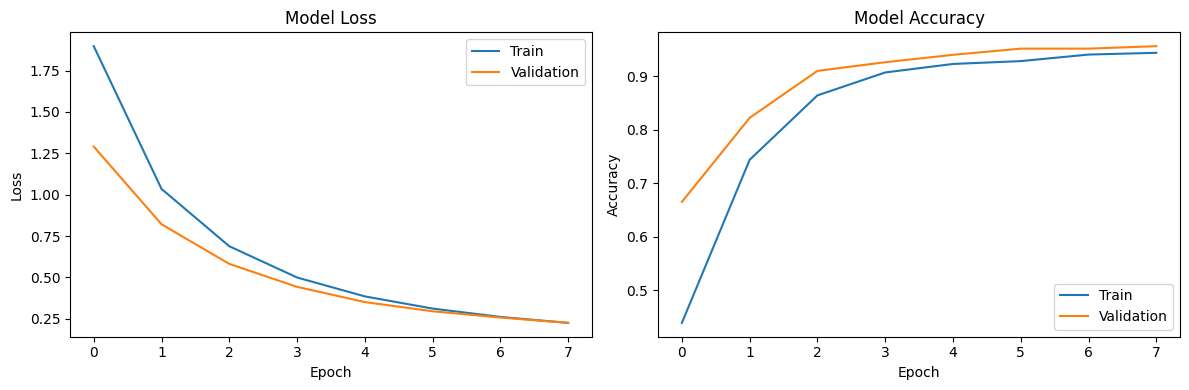

In [206]:
# Plot training & validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.tight_layout()
plt.show()

In [207]:
'_'.join(sorted(processed_data.keys()))

'a_c_d_g_h_i_l_m_n_o_t_u_y_z'

In [208]:
# 计算预测结果
y_pred = np.argmax(model.predict(X_test), axis=1)

# 计算F1分数
print("F1 Score (Weighted):", f1_score(y_test, y_pred, average='weighted'))
print("F1 Score (Macro):", f1_score(y_test, y_pred, average='macro'))

# 打印详细分类报告 - 修复target_names
target_names = [str(cls) for cls in encoder.classes_]  # 转换为字符串
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

# 计算并可视化混淆矩阵
cm = confusion_matrix(y_test, y_pred)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
F1 Score (Weighted): 0.9500251522910848
F1 Score (Macro): 0.9414402141536898

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        69
           1       1.00      1.00      1.00        63
           2       0.78      0.79      0.78        39
           3       0.82      0.80      0.81        46
           4       0.87      0.87      0.87        39
           5       0.95      1.00      0.98        62
           6       1.00      1.00      1.00        34
           7       1.00      1.00      1.00        45
           8       0.94      1.00      0.97        79
           9       1.00      1.00      1.00        67
          10       1.00      0.93      0.96        59
          11       0.87      0.89      0.88        45
          12       1.00      0.85      0.92        34
          13       1.00      1.00      1.00        41

    accuracy                           0.95     

### Saving

In [209]:
# save the model
import pickle
import time

# make the model name based on the gesture names
run_timestamp = str(time.time()).replace(".", "-")
model_name = '_'.join(sorted(processed_data.keys())) + "__" + run_timestamp

# make a model directory
model_dir = Path('./models')
model_dir.mkdir(parents=True, exist_ok=True)

with open(model_dir / f'{model_name}.keras', 'wb') as f:
    pickle.dump(model, f)
with open(model_dir / f'label_encoder_{model_name}.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

In [210]:
print(model_name)

a_c_d_g_h_i_l_m_n_o_t_u_y_z__1742224488-221914


In [211]:
model.predict(X_test[[0]])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


array([[2.6459999e-02, 1.5060120e-05, 1.4819630e-06, 3.1107999e-04,
        6.2597315e-18, 3.9356473e-07, 3.1841375e-07, 1.3543993e-15,
        1.2252884e-04, 1.6618688e-10, 3.1690815e-05, 2.4459265e-12,
        2.9468529e-06, 9.7305459e-01]], dtype=float32)

In [212]:
X_test.shape

(722, 20, 12)